In [27]:
import bpy
import os
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from PIL import Image
import warnings
from helper_functies import *
from IPython.display import Image as JupImage
import imageio
import bmesh
import mathutils
from mathutils import Vector
import cv2
from mathutils import Color

tmpdir=tempfile.TemporaryDirectory()
my_dpi = 96 # Afhankelijk van monitor

# Set a size of an image
size = [448, 448]

choice = "stefan"    # if you render an obj of a stefan, write "stefan"

# Set a path
path = 'C:/Users/cglab/Anaconda3/envs/blender/RenderingModule/'
realpath = r"C:\Users\cglab\Anaconda3\envs\blender\RenderingModule\mc23.jpg"    # You must set the same path as above and add mc23.jpg 

# Class of objects ========================================================== #
class Object:
    def __init__(self, name, obj, obj_data):
        # Re-Import the converted obj file
        file_loc = 'obj/'+ name[1] + '.obj'
        imported_object = bpy.ops.import_scene.obj(filepath = file_loc)
        self.object = bpy.context.selected_objects[0]
        self.object_data = bpy.data.objects[self.object.name]
    
        # Shadow of an object is removed
        self.object.active_material.use_shadeless = True
        
        # Set transform of an object
        self.object.location = (0, 0, 0)
        self.object.rotation_euler = (0, 0, 0)
        self.object.scale = (0, 0, 0)
        
        # Add an obj and a data in each array
        obj.append(self.object)
        obj_data.append(bpy.data.objects[self.object.name])
        n[0] += 1
        
    # Location(x, y, z) of an object 
    def location(self, x, y, z):
        self.object.location[0] = x
        self.object.location[1] = y
        self.object.location[2] = z
    
    # Scale(x, y, z) of an object
    def scale(self, x, y, z):
        self.object.scale[0] = x
        self.object.scale[1] = y
        self.object.scale[2] = z
    
    # Rotation(x, y, z) counter-clockwise of an object
    def rotation(self, x, y, z):
        self.object.rotation_euler[0] = x * (math.pi/180)
        self.object.rotation_euler[1] = y * (math.pi/180)
        self.object.rotation_euler[2] = z * (math.pi/180)
        
    # Color(r, g, b) of an object
    def color(self, r, g, b):
        self.object_data.active_material.diffuse_color = (r, g, b)
        self.object_data.active_material.diffuse_intensity = 1
# =========================================================================== #


# Preprocess of an obj ====================================================== #
def pre_obj(name):
    # Import an original obj file
    file_loc = 'obj/' + name[0] + '.obj'
    imported_object = bpy.ops.import_scene.obj(filepath = file_loc, use_split_objects = False, use_split_groups = False)
    obj = bpy.context.selected_objects[0]
    for i in range(1, len(obj.material_slots)):
        bpy.data.objects[obj.name].active_material_index = i
        bpy.ops.object.material_slot_remove({'object': obj})
    
    # Export the obj file
    blend_file_path = bpy.data.filepath
    directory = os.path.dirname(blend_file_path)
    target_file = os.path.join(directory, name[1] + '.obj')
    bpy.ops.export_scene.obj(filepath='obj/' + name[1] + '.obj')

    # Remove a mtl file and the original obj file
    os.remove('obj/' + name[1] + '.mtl')
    bpy.ops.object.delete(use_global = False)
# ==================================================================== #


# Get an image ======================================================= #
def get_img(tmpdir=tmpdir, size=size, name="result"):
    
    # Save a postprocessed image of wireframe
    if (mode == 'wireframe') and (os.path.isfile("wireframe.png")):
        img = cv2.imread(path+'wireframe.png')
        cv2.imwrite(os.path.join(path , name+".png"), img)
        cv2.waitKey(0)
        os.remove('wireframe.png')
        return img

    scene = bpy.context.scene
    
    # Set resolution of x and y
    scene.render.resolution_x = size[0]
    scene.render.resolution_y = size[1]
    scene.render.resolution_percentage = 100
    scene.render.filepath=tmpdir.name+"/image"
    
    # Render the image
    bpy.ops.render.render(write_still=True)
    
    # Save the rendered image
    save_loc = path+name+".png"
    bpy.data.images['Render Result'].save_render(filepath = save_loc)
        
    # Show the rendered image
    img=Image.open(tmpdir.name+"/image.png")
    return img
# ==================================================================== #


# Freestyle information ================================================== #
class Freestyle_info:
    def __init__(self, name, select_by_visibility=True, select_by_edge_types = True, select_by_face_marks = False,
                 select_by_group = False, select_by_image_border = True, silhouette = False, edge_mark = False, 
                 crease = False, border = False, contour = False, suggestive_contour = False, ridge_valley = False, 
                 external_contour = False, material_boundary = False, thickness = 2):
        self = bpy.context.scene.render.layers.active.freestyle_settings.linesets.new(name)
        
        # Refer to each function on the site.
        # http://builder.openhmd.net/blender-hmd-viewport-temp/render/freestyle/parameter_editor/line_set.html
        self.select_by_visibility = select_by_visibility
        self.select_by_edge_types = select_by_edge_types
        self.select_by_face_marks = select_by_face_marks
        self.select_by_group = select_by_group
        self.select_by_image_border = select_by_image_border
        
        self.select_silhouette = silhouette
        self.select_edge_mark = edge_mark
        self.select_crease = crease
        self.select_border = border
        self.select_contour = contour
        self.select_suggestive_contour = suggestive_contour
        self.select_ridge_valley = ridge_valley
        self.select_external_contour = external_contour
        self.select_material_boundary = material_boundary
        
        self.linestyle.thickness = thickness
# ==================================================================== #


#implement rendering mode ============================================ #
def render_pass(mode, obj, n):
    
    # Set a standard mode
    bpy.context.scene.render.use_freestyle = False
    bpy.context.scene.render.use_edge_enhance = False
    
    # Set a wireframe mode
    if mode == 'wireframe':
        # Set the color of the background and object to white
        bpy.context.scene.world.horizon_color = (1, 1, 1)    
        for i in range (0, n[0]):
            obj[i].active_material.diffuse_color = (1, 1, 1)
            obj[i].active_material.diffuse_intensity = 1
            obj[i].active_material.transparency_method = 'MASK'

        if (choice == "stefan"):
            sceneR = bpy.context.scene
            freestyle = sceneR.render.layers.active.freestyle_settings
            sceneR.render.use_freestyle = True
            freestyle.linesets.active_index = 0
            bpy.ops.scene.freestyle_lineset_remove()

            outline = Freestyle_info(name = "outline", external_contour = True, thickness =4)    # Outline
            details = Freestyle_info(name = "details", silhouette = True, crease = True, border = True)    # Detail
            
            return       
        # Set an img1 using 'Edge(threshold = 0)'
        bpy.context.scene.render.use_edge_enhance = True
        bpy.context.scene.render.edge_threshold = 1
        
        # Save and read the image of 'Edge(threshold = 0)'
        wire_img1 = get_img(size=size, name='wire_img1')
        wire_img1 = cv2.imread('wire_img1.png', cv2.IMREAD_COLOR)
        wire_img1 = wire_img1/255    # Normalize the image

        # Set an img2 using 'Edge(threshold > 0)'
        bpy.context.scene.render.use_edge_enhance = True
        bpy.context.scene.render.use_freestyle = False
        bpy.context.scene.render.edge_threshold = 100
        
        # Save and read the image of 'Edge(threshold > 0)'
        wire_img2 = get_img(size=size, name='wire_img2')
        wire_img2 = cv2.imread('wire_img2.png', cv2.IMREAD_COLOR)
        result = wire_img2.copy()    # Initialize a final image of wireframe        
        wire_img2 = wire_img2/255    # Normalize the image
        result_normal = result/255  
        threshold = 0.3 # threshold of difference
        
        #if a color of pixel in wire_img1 is different from one in wire_img2, we return a white pixel.
        for j in range(result.shape[1]):          # Column
            for i in range(result.shape[0]):      # Width  
                diff = abs(result_normal[i][j][0]- wire_img1[i][j][0])
                if(diff < threshold):           
                    result[i][j][0] = wire_img1[i][j][0] * 255
                    result[i][j][1] = result[i][j][0]  
                    result[i][j][2] = result[i][j][0]

#         kernel_sharpen_1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
#         output_1 = cv2.filter2D(result,-1,kernel_sharpen_1) 
        
        # Save the final image of wireframe
        cv2.imwrite(os.path.join(path , 'wireframe.png'), result)
        cv2.waitKey(0)
        
        # Remove wire_img1 and wire_img2
        os.remove('wire_img1.png')
        os.remove('wire_img2.png')
    
    # Set a normal mode
    elif mode == 'normal':
        for i in range (0, n[0]):
            obj[i].active_material.use_shadeless = True

            try:
                img = bpy.data.images.load(realpath)
            except:
                raise NameError("Cannot load image %s" % realpath)

            # Create image texture from image
            cTex = bpy.data.textures.new("NORMAL", type='IMAGE')
            cTex.image = img

            # Create material note that it is not same as the "texture"
            mat = bpy.data.materials.new("NORMAL")

            # Add texture slot for color texture
            mtex = mat.texture_slots.add()
            mtex.texture = cTex
            mtex.texture_coords = 'NORMAL'
            mtex.use_map_color_diffuse = True
            mtex.use_map_color_emission = True
            mtex.emission_color_factor = 1.0
            mtex.use_map_density = False
            mtex.mapping = 'FLAT'

            # assign material to object
            obj[i].data.materials.append(mat)

            # or overwrite an existing material slot via index operator
            obj[i].data.materials[0] = mat
# ====================================================================== #


# Class of camera ====================================================== #
class Camera:
    def __init__(self, mode):
        bpy.ops.object.camera_add()
        self.camera_obj = bpy.data.objects['Camera']
        bpy.ops.object.empty_add(
                type='PLAIN_AXES', radius=1, view_align=False,
                location=(0, 0, 0),
                layers=(True, False, False, False, False, False, False,
                        False, False, False, False, False, False, False,
                        False, False, False, False, False, False)
                )
        
        # Perspective or Orthographic
        self.camera_obj.data.type = mode
        
        # Camera tracks to an object
        self.ttc = self.camera_obj.constraints.new(type='TRACK_TO')
        self.ttc.target = bpy.context.selected_objects[0]
        self.ttc.track_axis = 'TRACK_NEGATIVE_Z'
        self.ttc.up_axis = 'UP_Y'    
        
        # Set location and lens of a camera
        self.x = 0
        self.y = 0
        self.z = 0
        self.camera_obj.data.lens = 35
    
    # Position of a camera
    def pos(self, r, theta, phi):
        # Spherical coord. is converted to cartesian coord.
        self.x = r * sin(theta * (math.pi/180)) * cos(phi * (math.pi/180))
        self.y = r * sin(theta * (math.pi/180)) * sin(phi * (math.pi/180))
        self.z = r * cos(theta * (math.pi/180))
    
        # Position of a camera
        self.camera_obj.location.x = self.x
        self.camera_obj.location.y = self.y
        self.camera_obj.location.z = self.z

    # Intrinsic parameter of a camera
    def intrinsic(self, focal, shift_x, shift_y):
        if self.camera_obj.data.type == 'PERSP':
            self.camera_obj.data.lens = focal    # Distance between lens and projected scene
            self.camera_obj.data.shift_x = shift_x
            self.camera_obj.data.shift_y = shift_y
# ============================================================================ #        

In [34]:
zero(my_dpi)
# Set the light, RECOMMENDED TYPE :  SUN or POINT 
bpy.ops.object.lamp_add(type='SUN',location=(5,2,1))

#Set the environment lighting and the color of background
bpy.context.scene.world.light_settings.use_environment_light = True
bpy.context.scene.world.horizon_color = (0, 0, 0)    # the color of background

# obj and the # of objects
obj = []
obj_data = []
n = [0]

# Preprocess of obj file
name_1 = ['chair braket(4ea)', 'chair braket(4ea)_b']    # name (before, after)
# name_1 = ['3094', '3094_b']    # name (before, after)
# name_1 = ['000_', '000_b']    # name (before, after)


pre_obj(name = name_1)
# name_2 = ['chair braket(4ea)', 'chair braket(4ea)_b2']
# pre_obj(name_2)

# Object's location, rotation, scale, and color
obj1 = Object(name_1, obj, obj_data)
obj1.location(0, 0, 0)    # lotation (x, y, z)
obj1.rotation(90, 0, 90)    # rotation (x, y, z) counter-clockwise
obj1.scale(10, 10, 10)    # scale (x, y, z)
obj1.color(1, 0, 1)    # color (r, g, b)

# obj2 = Object(name_2, obj, obj_data)
# obj2.location(0, 0, 0)
# obj2.rotation(90, 0, 90)
# obj2.scale(15, 15, 15)
# obj2.color(0, 1, 1)



(  0.0010 sec |   0.0010 sec) Importing OBJ 'obj/chair braket(4ea).obj'...
  (  0.0020 sec |   0.0010 sec) Parsing OBJ file...
    (  0.0080 sec |   0.0060 sec) Done, loading materials and images...
    (  0.0080 sec |   0.0060 sec) Done, building geometries (verts:378 faces:756 materials: 0 smoothgroups:0) ...
    (  0.0110 sec |   0.0090 sec) Done.
  (  0.0110 sec |   0.0100 sec) Finished importing: 'obj/chair braket(4ea).obj'
Progress: 100.00%

    (  0.0000 sec |   0.0000 sec) OBJ Export path: 'obj/chair braket(4ea)_b.obj'
          (  0.0170 sec |   0.0160 sec) Finished writing geometry of 'chair braket(4ea).008'.
          (  0.0170 sec |   0.0000 sec) Finished writing geometry of 'Sun'.
          (  0.0190 sec |   0.0010 sec) Finished writing geometry of 'Camera'.
          (  0.0210 sec |   0.0010 sec) Finished writing geometry of 'Lamp'.
      (  0.0210 sec |   0.0200 sec) Finished exporting geometry, now exporting materials
      (  0.0230 sec |   0.0220 sec) OBJ Export Finis

<Figure size 800x800 with 0 Axes>

In [35]:
# Camera
cam = Camera('PERSP')    # 'PERSP' or 'ORTHO'
cam.pos(1, 45, 45)    # (radius, theta, phi)
cam.intrinsic(35, 0, 0)    # (focal length, shift_x, shift_y)

# Render passes
mode = 'wireframe'    # 'wireframe', 'normal', and anything(default)
render_pass(mode, obj, n)

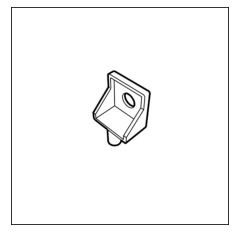

In [36]:
# Save and show Image
result_name = 'result'
# name the file
plt.imshow(get_img(size = size, name = result_name))    # save the file
plt.xticks([]);plt.yticks([])
plt.show()

tmpdir.cleanup()